# Entanglement in Action

In the following, we will look at some examples of entanglement:

* Quantum Teleportation
* Superdense Coding
* CHSH Game

First, let's import all relevant libraries:

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

## Quantum Teleportation

Now, we move on to the first example where we implement a Quantum teleportation protocol. Under Quantum teleportation protocol, we understand a protocol where a sender (Alice) transmits a qubit to a receiver (Bob) by making use of a shared entangled quantum state along with two bits of classical communication.

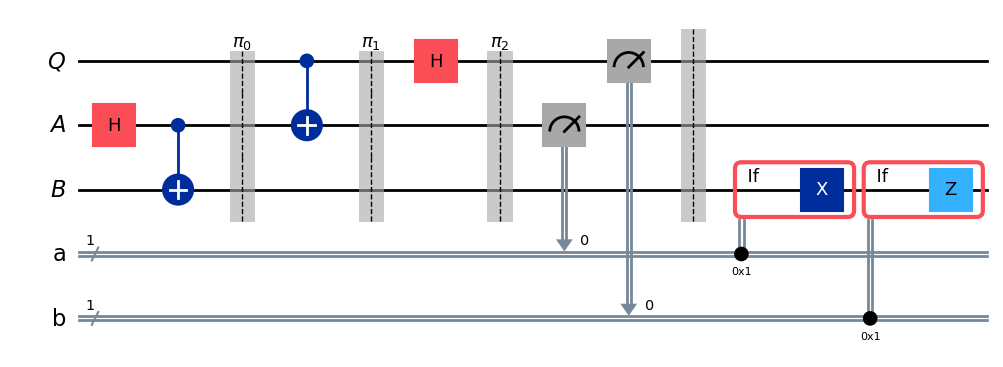

In [2]:
# Qubit that will be transmitted
qubit = QuantumRegister(1, "Q")

# Alice
ebit0 = QuantumRegister(1, "A")
# Bob
ebit1 = QuantumRegister(1, "B")

#Two bits of classical communication
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

# Set up the protocol
protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)
 
# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
#The barrier will make the output visually more structured
protocol.barrier(label='$\pi_0$')
 
# Alice's operations
protocol.cx(qubit, ebit0)
protocol.barrier(label='$\pi_1$')
protocol.h(qubit)
protocol.barrier(label='$\pi_2$')
 
# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()
 
# Bob uses the classical bits to conditionally apply gates
# this is done with the if_test function
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)
 
display(protocol.draw(output="mpl"))

Let's first describe the quantum circuit above, followed by verifying that the implemented protocol works.

### Description

The first step, the preparation of the shared state between A(lice) and B(ob) is strictly speaking not part of the protocol. By applying a Hadamard gate, followed by a CNOT gate, we create the $|\phi^+\rangle$ state. After that the protocol starts. Before applying any gates, the general state, we have is
\begin{equation}
|\pi_0\rangle = |\phi^+\rangle \otimes (\alpha|0\rangle+\beta|1\rangle) = \frac{\alpha|000\rangle + \alpha|110\rangle +\beta |001\rangle + \beta |111\rangle}{\sqrt{2}}
\end{equation}
if we assume that Q is in the state $\alpha|0\rangle+\beta|1\rangle$. The order of the qubits will be (B,A,Q).

1. CNOT gate on pair (A,Q), with Q being the control, and A being the target, which transforms the state into
   \begin{equation}
   |\pi_1\rangle=\frac{\alpha|000\rangle+\alpha|110\rangle+\beta|011\rangle+\beta|101\rangle}{\sqrt{2}}
   \end{equation}
   followed by a Hadamard gate on Q, after which we have
   \begin{equation}
   |\pi_2\rangle=\frac{\alpha|000\rangle+\alpha|001\rangle+\alpha|110\rangle+\alpha|111\rangle+\beta|010\rangle-\beta|011\rangle+\beta|100\rangle-\beta|101\rangle}{2}
   \end{equation}
   which can be written as
   \begin{align}
   |\pi_2\rangle = &\frac12 (\alpha|0\rangle + \beta |1\rangle)|00\rangle\\
                   +&\frac12 (\alpha|0\rangle - \beta |1\rangle)|01\rangle\\
                   +&\frac12 (\alpha|1\rangle + \beta |0\rangle)|10\rangle\\
                   +&\frac12 (\alpha|1\rangle - \beta |0\rangle)|11\rangle\\ 
   \end{align}
   Here, we can see what gates have to be applied to transform B into $(\alpha|0\rangle + \beta |1\rangle)$ based on the qubits A, and Q in (B,A,Q).
4. Alice measures both A, and Q, and transmits the classical outcomes to Bob (A $\to a$, and Q $\to b$).
5. Depending on the outcome, Bob is applying a gate:
   - if a=1, apply X gate to B
   - if b=1, apply Z gate to B

### Test

To test the implemented protocol, we apply a radomly generated single-qubit gate $U$ to the initialized $|0\rangle$ state of Q. By applying the inverse $U^{-1}$ to the final B state which should then return $|0\rangle$.

A random gate can be defined as

In [3]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)
 
display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

The test circuit is structured as follows. First, the random gate is applied to Q, then we run the teleportation protocol, and finally, we apply the inverse of the random gate to B and measure the outcome (which should be 0 with certainty).

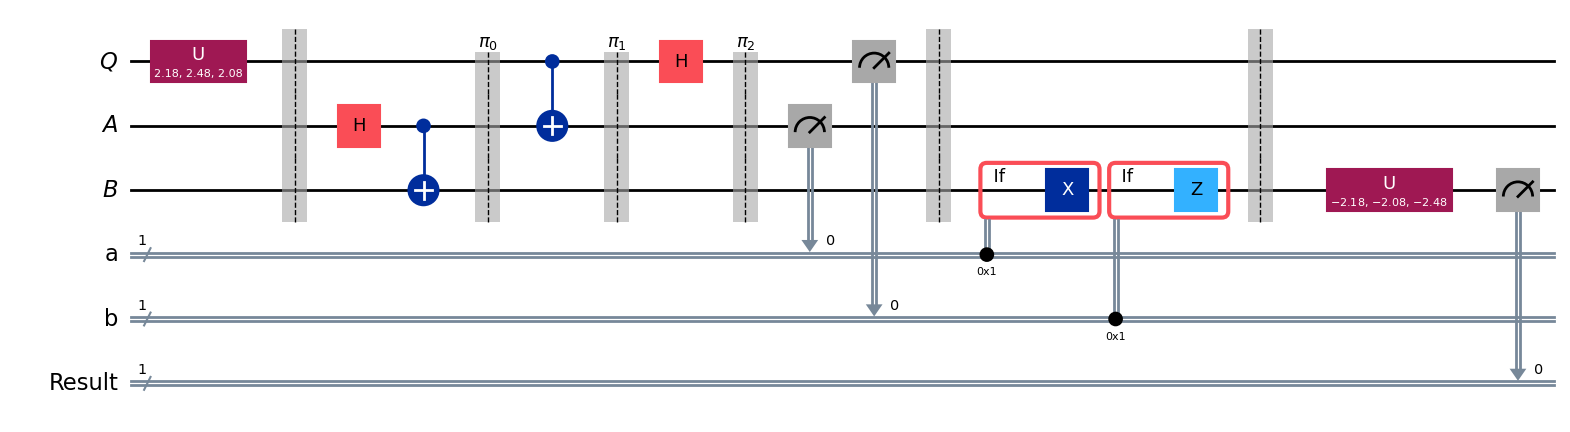

In [4]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.
 
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)
 
# Start with the randomly selected gate on Q
 
test.append(random_gate, qubit)
test.barrier()
 
# Append the entire teleportation protocol from above.
 
test = test.compose(protocol)
test.barrier()
 
# Finally, apply the inverse of the random unitary to B and measure.
 
test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)
 
display(test.draw(output="mpl"))

Running the circuit on a quantum simulator should always yield 0 for the measurement, while the (A,Q) qubits should be uniformly distributed. First, we show all options, and second we only focus on the test qubit measurement. Remember that the counting for (B,A,Q) is (2,1,0).

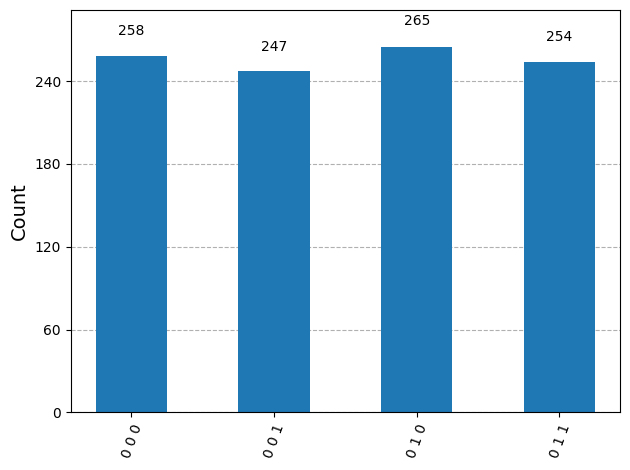

In [7]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

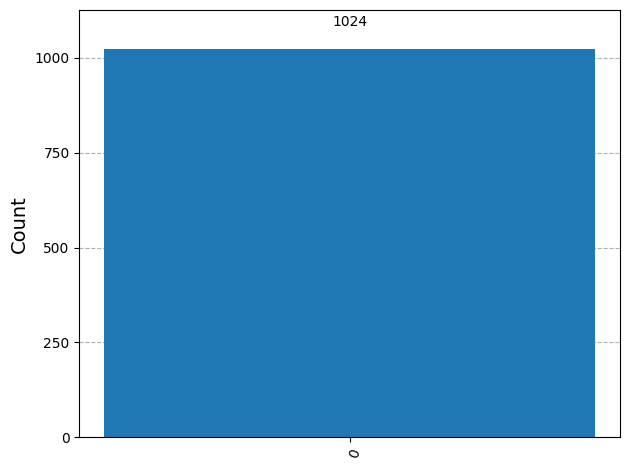

In [8]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

## Superdense Coding

Superdense coding is in some sense the opposite of quantum teleportation. Instead of transmitting one qubit by using two classical bits, we use one qubit to transmit two classical bits. Again, Alice and Bob share one e-bit, where we use the same conventions (A,B) as before and the shared e-bit is in the state $|\phi^+\rangle$. The classical bits to be transmitted will be called c, and d, and for which we make an arbitrary choice:

In [9]:
c = "1"
d = "0"

and the protocol is as follows

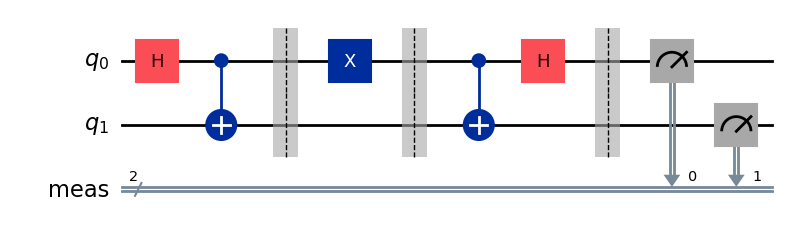

In [10]:
protocol = QuantumCircuit(2)
 
# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()
 
# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()
 
# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()
 
display(protocol.draw(output="mpl"))

The `measure_all()` function simply measures all of the qubits and stores the results in a single classical register (which has the needed amount of bits, in this case two).

### Description 

Alice has two classical bits c, and d. What she's doing now is:

1. If $d=1$, Alice performs a $Z$ gate on her qubit A (and nothing if $d=0$).
2. If $c=1$, Alice performs an $X$ gate on her qubit A (and nothing if $c=0$).

Then she sends her qubit to Bob. 

Bob performs:

1. a controlled-NOT gate, with A being the control and B being the target
2. followed by a Hadamard gate to A.
3. Finally, he measures B to obtain c and A to obtain d with standard basis measurements.

**Analysis:** Initially, Alice and Bob share $|\phi^+\rangle$. Alice and Bob's action are the following
\begin{align}
(\mathbb{1}\otimes \mathbb{1})|\phi^+\rangle&\xrightarrow{\text{Alice}}|\phi^+\rangle &\xrightarrow{\text{Bob}} |00\rangle\\
(\mathbb{1}\otimes Z)|\phi^+\rangle&\xrightarrow{\text{Alice}}|\phi^-\rangle &\xrightarrow{\text{Bob}} |01\rangle\\
(\mathbb{1}\otimes X)|\phi^+\rangle&\xrightarrow{\text{Alice}}|\psi^+\rangle &\xrightarrow{\text{Bob}} |10\rangle\\
(\mathbb{1}\otimes XZ)|\phi^+\rangle&\xrightarrow{\text{Alice}}|\psi^-\rangle &\xrightarrow{\text{Bob}} -|11\rangle
\end{align}

### Test

Running the `Aer simulator` to check the results, yields

Measured 10 with frequency 1024


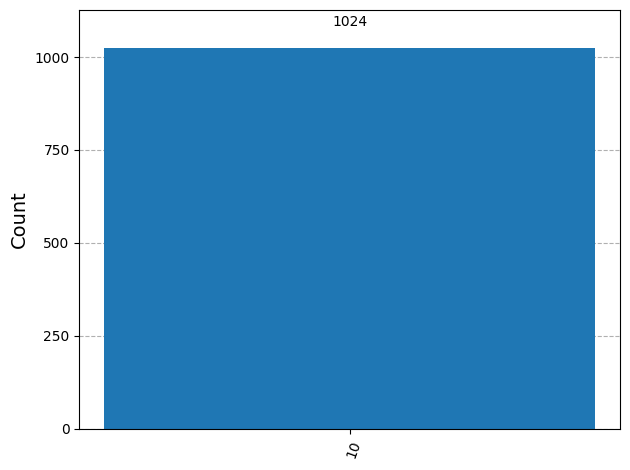

In [11]:
result = AerSimulator().run(protocol).result()
statistics = result.get_counts()
 
for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")
 
display(plot_histogram(statistics))

Alternatively, we can choose the classical bits randomly by using a qubit. The following code shows this

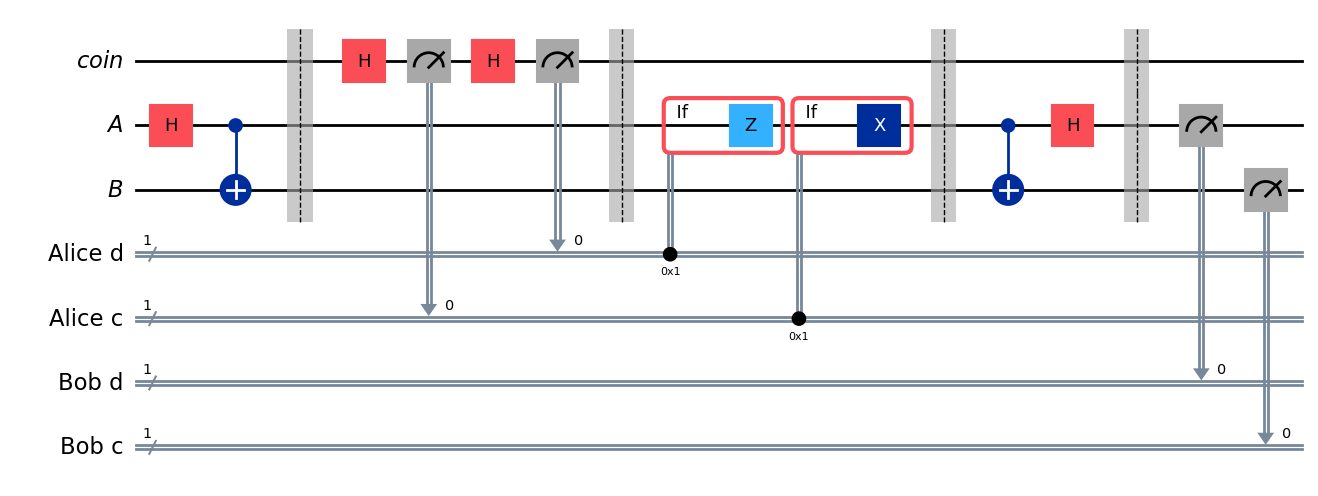

In [13]:
rbg = QuantumRegister(1, "coin")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
 
Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")
 
test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)
 
# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()
 
# Use the 'coin' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()
 
# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()
 
# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()
 
Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)
 
display(test.draw(output="mpl"))

Again running the simulator gives

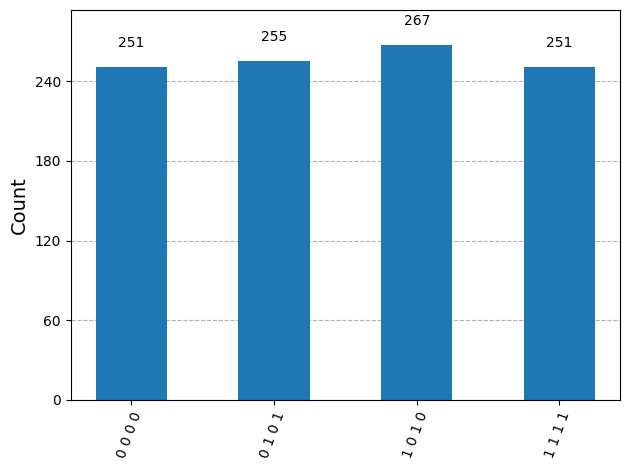

In [14]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

## The CHSH game